In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#change the tickers here according to what's in the portfolio
tickers = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

start_date = '2017-01-01'
end_date = '2022-01-01'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [3]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 33 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LHX     1259 non-null   float64
 1   ODFL    1259 non-null   float64
 2   GLDD    1259 non-null   float64
 3   HSON    1259 non-null   float64
 4   ISSC    1259 non-null   float64
 5   KRNT    1259 non-null   float64
 6   RCII    1259 non-null   float64
 7   SAIA    1259 non-null   float64
 8   AMD     1259 non-null   float64
 9   EPAM    1259 non-null   float64
 10  APPS    1259 non-null   float64
 11  ASML    1259 non-null   float64
 12  AUDC    1259 non-null   float64
 13  DSGX    1259 non-null   float64
 14  TTD     1259 non-null   float64
 15  TSLA    1259 non-null   float64
 16  CHDN    1259 non-null   float64
 17  CLAR    1259 non-null   float64
 18  FIVE    1259 non-null   float64
 19  FOXF    1259 non-null   float64
 20  HTHT    1259 non-null   float64
 21  LULU    1259 non-nu

## Function that saves dataframe to CSV

In [4]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [5]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Close']
    save_dataframe_to_csv('close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [6]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [7]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Close'] / df['Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [8]:
for ticker in tickers:
    df = get_df_from_csv('close', ticker)
    add_daily_return_to_df('close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [9]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('close', x)
    
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [10]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Close'].item()

## Returns the value of portfolio by date

In [11]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [12]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [13]:
#change to the list of stocks we using
port_list = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX']

#add in the weightage of stocks
port_shares = [0.026583,0.034851,0.096294,0.048018,0.041109,0.006993,0.046149,0.048508,0.008168,0.018970,0.017408,
              0.006022,0.000022,0.043910,0.047034,0.000492,0.009466,0.064368,0.135632,0.079597,0.001491,0.009026,
              0.008944,0.003649,0.000157,0.004097,0.043038,0.002017,0.046972,0.011787,0.031827,0.006205,0.012434,
              0.038754,0.000000]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.730606,2.016246,0.433323,0.681856,0.143059,0.092657,0.537174,2.178009,0.093360,1.207630,...,0.013684,3.215369,0.072430,0.114142,0.367165,0.158180,0.654814,0.024172,26.632806,NaN
2017-01-04,2.745492,2.024611,0.452582,0.705865,0.144293,0.090210,0.542712,2.185285,0.093360,1.220909,...,0.013889,3.306179,0.073399,0.112733,0.380720,0.153406,0.655744,0.024209,26.962344,0.012373
2017-01-05,2.748948,2.000680,0.430434,0.701063,0.148815,0.087413,0.517330,2.131927,0.091808,1.228308,...,0.013848,3.279926,0.072269,0.114142,0.390268,0.157225,0.647057,0.023165,26.847798,-0.004248
2017-01-06,2.779253,2.000447,0.428508,0.691459,0.147992,0.088461,0.496102,2.177039,0.092462,1.268524,...,0.013971,3.384939,0.072249,0.114142,0.390150,0.157544,0.642342,0.023898,26.870116,0.000831
2017-01-09,2.715188,1.989527,0.418879,0.672252,0.154159,0.093357,0.498871,2.139203,0.093850,1.267955,...,0.014380,3.458964,0.072047,0.111324,0.381192,0.163909,0.639053,0.023388,26.686146,-0.006847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,5.591202,12.393016,1.516630,1.337301,0.263509,1.072446,2.270531,16.155589,1.260812,13.222090,...,0.022124,13.239349,0.459674,2.975676,3.157266,0.701785,2.378749,0.015567,146.175303,0.019665
2021-12-28,5.639849,12.429261,1.506038,1.353147,0.271319,1.066083,2.258071,16.016857,1.250929,12.941334,...,0.022533,13.171779,0.440311,2.852610,2.991187,0.698284,2.387250,0.015480,145.087112,-0.007444
2021-12-29,5.645432,12.574589,1.507964,1.347385,0.268853,1.079579,2.277915,16.270068,1.210988,12.858625,...,0.021878,13.255273,0.444688,2.794364,3.039867,0.684281,2.388615,0.016090,146.770713,0.011604


## Get old data for portfolio

In [14]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2022-01-01', 
                                    port_shares, port_list)
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.730606,2.016246,0.433323,0.681856,0.143059,0.092657,0.537174,2.178009,0.093360,1.207630,...,0.013684,3.215369,0.072430,0.114142,0.367165,0.158180,0.654814,0.024172,26.632806,NaN
2017-01-04,2.745492,2.024611,0.452582,0.705865,0.144293,0.090210,0.542712,2.185285,0.093360,1.220909,...,0.013889,3.306179,0.073399,0.112733,0.380720,0.153406,0.655744,0.024209,26.962344,0.012373
2017-01-05,2.748948,2.000680,0.430434,0.701063,0.148815,0.087413,0.517330,2.131927,0.091808,1.228308,...,0.013848,3.279926,0.072269,0.114142,0.390268,0.157225,0.647057,0.023165,26.847798,-0.004248
2017-01-06,2.779253,2.000447,0.428508,0.691459,0.147992,0.088461,0.496102,2.177039,0.092462,1.268524,...,0.013971,3.384939,0.072249,0.114142,0.390150,0.157544,0.642342,0.023898,26.870116,0.000831
2017-01-09,2.715188,1.989527,0.418879,0.672252,0.154159,0.093357,0.498871,2.139203,0.093850,1.267955,...,0.014380,3.458964,0.072047,0.111324,0.381192,0.163909,0.639053,0.023388,26.686146,-0.006847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,5.591202,12.393016,1.516630,1.337301,0.263509,1.072446,2.270531,16.155589,1.260812,13.222090,...,0.022124,13.239349,0.459674,2.975676,3.157266,0.701785,2.378749,0.015567,146.175303,0.019665
2021-12-28,5.639849,12.429261,1.506038,1.353147,0.271319,1.066083,2.258071,16.016857,1.250929,12.941334,...,0.022533,13.171779,0.440311,2.852610,2.991187,0.698284,2.387250,0.015480,145.087112,-0.007444
2021-12-29,5.645432,12.574589,1.507964,1.347385,0.268853,1.079579,2.277915,16.270068,1.210988,12.858625,...,0.021878,13.255273,0.444688,2.794364,3.039867,0.684281,2.388615,0.016090,146.770713,0.011604


## Forecasting

In [15]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [16]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [17]:
tot_port_df

,LHX,ODFL,GLDD,HSON,ISSC,KRNT,RCII,SAIA,AMD,EPAM,...,EDAP,ICLR,MEDP,OPRX,RGEN,XOMA,SBAC,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,2.730606,2.016246,0.433323,0.681856,0.143059,0.092657,0.537174,2.178009,0.093360,1.207630,...,0.013684,3.215369,0.072430,0.114142,0.367165,0.158180,0.654814,0.024172,26.632806,NaN
2017-01-04,2.745492,2.024611,0.452582,0.705865,0.144293,0.090210,0.542712,2.185285,0.093360,1.220909,...,0.013889,3.306179,0.073399,0.112733,0.380720,0.153406,0.655744,0.024209,26.962344,0.012373
2017-01-05,2.748948,2.000680,0.430434,0.701063,0.148815,0.087413,0.517330,2.131927,0.091808,1.228308,...,0.013848,3.279926,0.072269,0.114142,0.390268,0.157225,0.647057,0.023165,26.847798,-0.004248
2017-01-06,2.779253,2.000447,0.428508,0.691459,0.147992,0.088461,0.496102,2.177039,0.092462,1.268524,...,0.013971,3.384939,0.072249,0.114142,0.390150,0.157544,0.642342,0.023898,26.870116,0.000831
2017-01-07,2.779253,2.000447,0.428508,0.691459,0.147992,0.088461,0.496102,2.177039,0.092462,1.268524,...,0.013971,3.384939,0.072249,0.114142,0.390150,0.157544,0.642342,0.023898,26.870116,0.000831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,5.591202,12.393016,1.516630,1.337301,0.263509,1.072446,2.270531,16.155589,1.260812,13.222090,...,0.022124,13.239349,0.459674,2.975676,3.157266,0.701785,2.378749,0.015567,146.175303,0.019665
2021-12-28,5.639849,12.429261,1.506038,1.353147,0.271319,1.066083,2.258071,16.016857,1.250929,12.941334,...,0.022533,13.171779,0.440311,2.852610,2.991187,0.698284,2.387250,0.015480,145.087112,-0.007444
2021-12-29,5.645432,12.574589,1.507964,1.347385,0.268853,1.079579,2.277915,16.270068,1.210988,12.858625,...,0.021878,13.255273,0.444688,2.794364,3.039867,0.684281,2.388615,0.016090,146.770713,0.011604


In [18]:
# Delete all unneeded columns - basically delete all except Total
del_col = ['LHX','ODFL','GLDD','HSON','ISSC','KRNT','RCII','SAIA','AMD','EPAM','APPS','ASML','AUDC','DSGX',
          'TTD','TSLA','CHDN','CLAR','FIVE','FOXF','HTHT','LULU','IDXX','BDSI','CDMO','EDAP','ICLR','MEDP',
          'OPRX','RGEN','XOMA','SBAC','^FVX', "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [19]:
tot_port_df

,Total
Date,
2017-01-03,26.632806
2017-01-04,26.962344
2017-01-05,26.847798
2017-01-06,26.870116
2017-01-07,26.870116
...,...
2021-12-27,146.175303
2021-12-28,145.087112
2021-12-29,146.770713


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


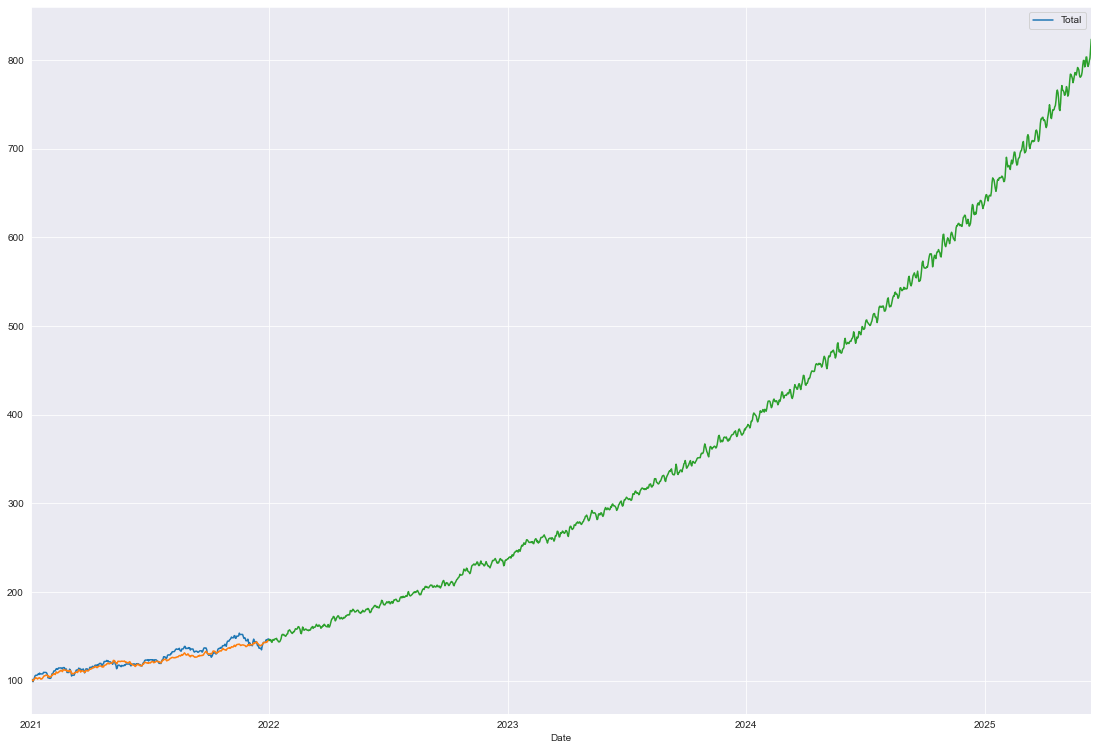

In [20]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+1260, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [21]:
forecast

2021-12-31    146.110559
2022-01-01    146.612712
2022-01-02    145.303211
2022-01-03    146.462668
2022-01-04    144.268607
                 ...    
2025-06-09    794.739833
2025-06-10    798.931165
2025-06-11    802.184196
2025-06-12    813.241408
2025-06-13    823.408817
Freq: D, Length: 1261, dtype: float64

In [22]:
forecast_df = pd.DataFrame(forecast)

In [23]:
forecast_df

,0
2021-12-31,146.110559
2022-01-01,146.612712
2022-01-02,145.303211
2022-01-03,146.462668
2022-01-04,144.268607
...,...
2025-06-09,794.739833
2025-06-10,798.931165
2025-06-11,802.184196
2025-06-12,813.241408


In [24]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [25]:
return_series

,0
2021-12-31,NaN
2022-01-01,0.003437
2022-01-02,-0.005526
2022-01-03,0.002410
2022-01-04,-0.012607
...,...
2025-06-09,4.439305
2025-06-10,4.467991
2025-06-11,4.490255
2025-06-12,4.565932


In [26]:
#calculate annualized volatility
annualized_vol = np.sqrt(np.log(forecast / forecast.shift(1)).var()) * np.sqrt(252)
annualized_vol*100

10.862408577878776